In [4]:
# Training Dataset 
# !unzip /content/drive/MyDrive/dataset/Files.zip

Archive:  /content/drive/MyDrive/dataset/Files.zip
replace Files/data/CameraRGB/002128.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import os
import math
import numpy as np
import pandas as pd 
import imageio
import cv2
import random
from PIL import Image
from sklearn import model_selection
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [10]:
path = './'
image_path = os.path.join(path, 'Files/data/CameraRGB/')
mask_path = os.path.join(path, 'Files/data/CameraMask/')
image_list = os.listdir(image_path)

mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]

mask_list = [mask_path+i for i in mask_list]
print(len(image_list))
print(len(mask_list))

1060
1060


Text(0.5, 1.0, 'Segmentation')

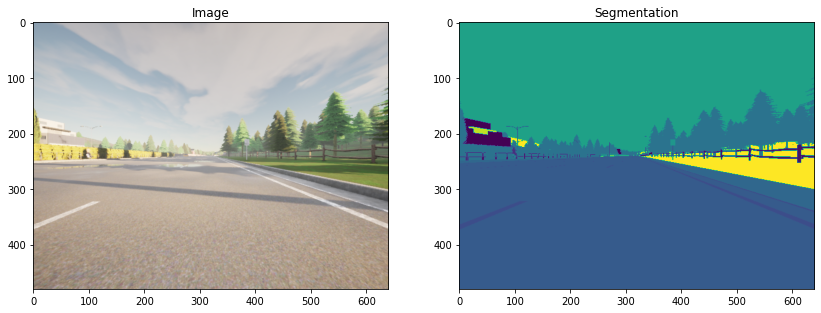

In [11]:
N = 2

img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize= (14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [12]:
img_ds = tf.data.Dataset.list_files(image_list, shuffle= False) 
mask_ds = tf.data.Dataset.list_files(mask_list, shuffle= False) 

In [13]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for img, mask in dataset.take(1):
  print(img)
  print(mask)

tf.Tensor(b'./Files/data/CameraRGB/003872.png', shape=(), dtype=string)
tf.Tensor(b'./Files/data/CameraMask/003872.png', shape=(), dtype=string)


In [14]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

In [15]:
def preprocess(image, mask):
    input_image = tf.image.resize(image, (256, 512), method='nearest')
    input_mask = tf.image.resize(mask, (256, 512), method='nearest')

    return input_image, input_mask

In [16]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [17]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

Input and True Mask ready for Training

(256, 512, 1)


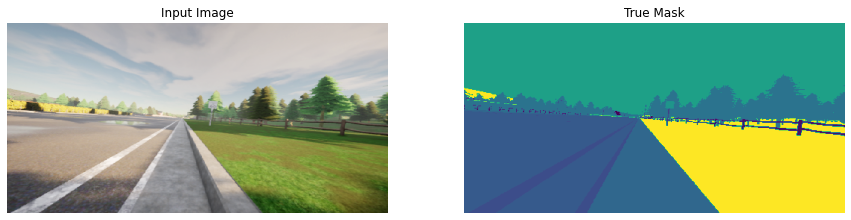

In [18]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

UNet Convolution Block with 2 Conv2D Block


In [19]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
                  
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size=3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    
    if dropout_prob > 0:

        conv = Dropout(dropout_prob)(conv)
         
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=2)(conv)

        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

UNet UpSampling Block


In [20]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 kernel_size=(3,3),    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters,   # Number of filters
                 kernel_size=(3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 kernel_size=(3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [21]:
def UNet_model(input_size, n_filters=32, n_classes=23):

    inputs = Input(input_size)
    
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters)
    cblock3 = conv_block(cblock2[0], n_filters * 8)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob=.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob=.3, max_pooling=False)
    
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 16)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 8)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 8)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)

    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [22]:
img_height = 256
img_width = 512
num_channels = 3

UNet = UNet_model((img_height, img_width, num_channels))
UNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

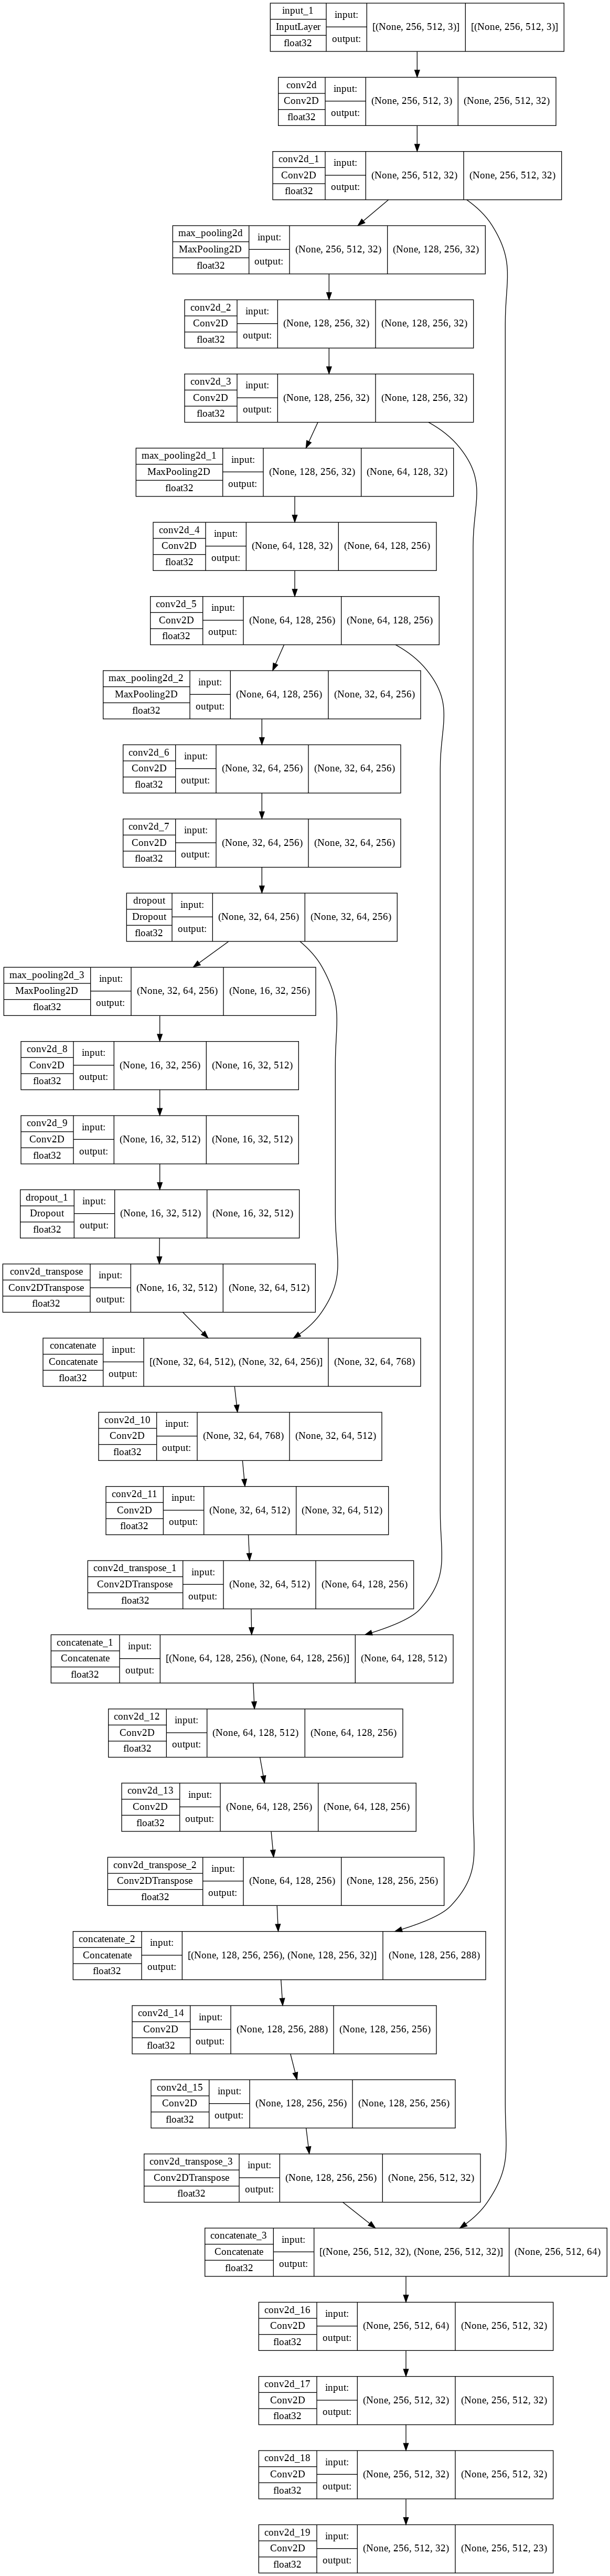

In [23]:
tf.keras.utils.plot_model(UNet, to_file='model.png', show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96, layer_range=None)

In [24]:
UNet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
EPOCHS = 30
BUFFER_SIZE = 500 
BATCH_SIZE  = 32
processed_image_ds.batch(BATCH_SIZE)

train_ds = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)

model_history = UNet.fit(train_ds, epochs=EPOCHS)

(TensorSpec(shape=(256, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 512, 1), dtype=tf.uint8, name=None))
Epoch 1/30
34/34 [==============================] - 94s 2s/step - loss: 2.1988 - accuracy: 0.3443
Epoch 2/30
34/34 [==============================] - 57s 2s/step - loss: 1.5028 - accuracy: 0.5084
Epoch 3/30
34/34 [==============================] - 57s 2s/step - loss: 1.3507 - accuracy: 0.6323
Epoch 4/30
34/34 [==============================] - 57s 2s/step - loss: 0.7835 - accuracy: 0.8049
Epoch 5/30
34/34 [==============================] - 57s 2s/step - loss: 0.5654 - accuracy: 0.8515
Epoch 6/30
34/34 [==============================] - 57s 2s/step - loss: 0.4453 - accuracy: 0.8779
Epoch 7/30
34/34 [==============================] - 57s 2s/step - loss: 0.3642 - accuracy: 0.8933
Epoch 8/30
34/34 [==============================] - 57s 2s/step - loss: 0.3459 - accuracy: 0.8965
Epoch 9/30
34/34 [==============================] - 57s 2s/step - loss: 0.3420 - accuracy: 0.

In [26]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

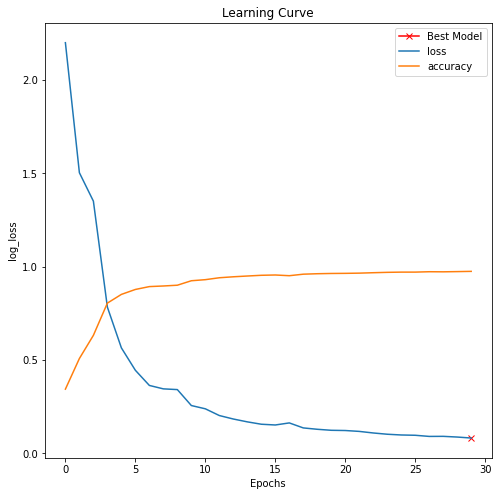

In [27]:
plt.figure(figsize=(8, 8))
plt.title("Learning Curve")
plt.plot(np.argmin(model_history.history["loss"]), np.min(model_history.history["loss"]), marker="x", color="r", label="Best Model")
plt.plot(model_history.history["loss"], label="loss")
plt.plot(model_history.history["accuracy"], label="accuracy")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [28]:
def show_predictions(dataset=None, num=1):

    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = UNet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(UNet.predict(sample_image[tf.newaxis, ...]))])

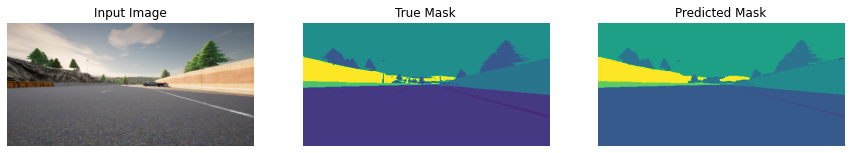

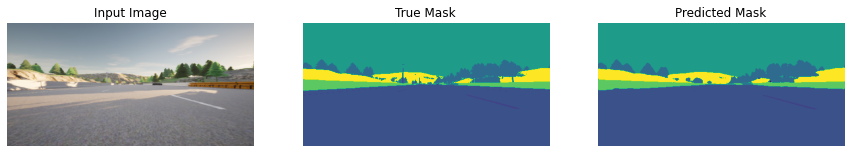

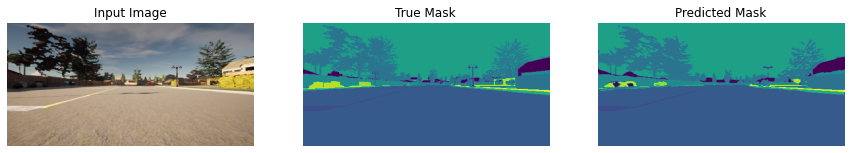

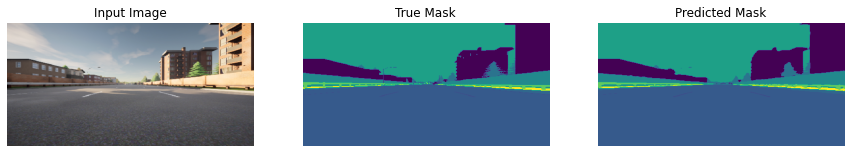

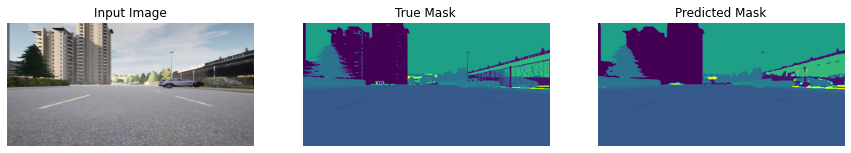

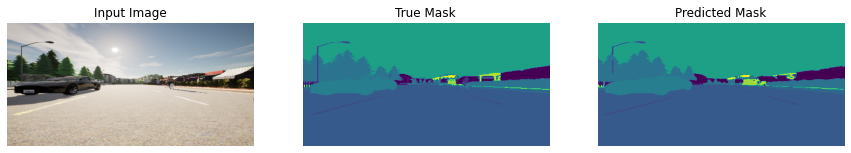

In [29]:
show_predictions(train_ds, 6)

In [30]:
def LoadImage(img, path, rotation=0.0, flip=False, cut_bottom=58, size=(256, 512)):
  
    img = Image.open(path + '/' + img) 
    
    crop_rectangle = (50, 50, 200, 200)
    cropped_im = img.crop(crop_rectangle)
    print(cropped_im)
    tf.image.crop_and_resize(img,crop_rectangle )
    cropped_im = tf.image.convert_image_dtype(cropped_im, tf.float32)
    input_image = tf.image.resize(cropped_im, (256, 512), method='nearest')
    return input_image

def Generate(path, batch_size=32):
    
    file = os.listdir(path)
    imgs=[]
    while True:

        for img in file:

            img1 = LoadImage(img, path)   
            imgs.append(img1)

    return tf.data.Dataset.list_files(imgs)

In [ ]:
# def real_world_predictions(dataset=None, num=1):
  
#     if dataset:
#         for image in dataset.take(num):
#             pred_mask = UNet.predict(image)
#             display([image[0], create_mask(pred_mask)])
#     else:
#         display([sample_image, create_mask(UNet.predict(sample_image[tf.newaxis, ...]))])


# real_world_predictions(test, 6)